# Investigate future prediction capacity of trained models
Evaluate the ability of trained models optimized for next timestep (i.e. 1 step ahead) prediction to generalize to predicting longer horizons (i.e. an arbitrary number of future timesteps).

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils import DEVICE
from datetime import datetime
from omegaconf import OmegaConf
from train._main import train_model
from data._main import get_dataset
from data._utils import load_Kato2015, load_Uzel2022
from train._utils import model_predict, make_predictions
from models._utils import LinearNN, NetworkLSTM, NeuralTransformer
from visualization._utils import plot_targets_predictions, plot_correlation_scatterplot

In [2]:
# load your trained model checkpoint of choice
PATH = "../logs/hydra/2023_04_21_22_42_57/1/checkpoints/400_epochs_38800_worms.pt"
checkpoint = torch.load(PATH, map_location=torch.device(DEVICE))
for key in checkpoint.keys():
    print(key)

epoch
loss
dataset_name
model_name
optimizer_name
learning_rate
smooth_data
timestamp
covered_neurons
worm_timesteps
input_size
hidden_size
num_layers
num_worm_cohorts
num_unique_worms
model_state_dict
optimizer_state_dict


In [3]:
# get checkpoint variables
model_name = checkpoint["model_name"]
train_dataset_name = checkpoint["dataset_name"]
input_size = checkpoint["input_size"]
hidden_size = checkpoint["hidden_size"]
model_state_dict = checkpoint["model_state_dict"]
optimizer_state_dict = checkpoint["optimizer_state_dict"]
num_layers = checkpoint["num_layers"]
smooth_data = checkpoint["smooth_data"]
epoch = checkpoint["epoch"]

print(
    "{} model was trained on dataset {} for {} epochs.".format(
        model_name, train_dataset_name, epoch
    )
)

NetworkLSTM model was trained on dataset Flavell2023_Kaplan2020_Kato2015_Nichols2017_Skora2018 for 400 epochs.


In [4]:
# load model checkpoint
model = eval(model_name)(input_size, hidden_size, num_layers)
model.load_state_dict(model_state_dict)
model.eval()
print(model)

# load optimizer checkpoint
optimizer = torch.optim.SGD(model.parameters(), lr=0.0)  # turn off learning
optimizer.load_state_dict(optimizer_state_dict)
print(optimizer)

# ideally, evaluate the model on a test dataset that it was not trained on
# test_dataset = load_Kato2015() # dataset of multiple worms
test_dataset = load_Uzel2022()  # dataset of multiple worms
print("Dataset keys:", list(test_dataset["worm0"].keys()))

# determine if the test dataset was seen during training
test_dataset_name = test_dataset["worm0"]["dataset"]
in_distribution = test_dataset_name in train_dataset_name
dataset_inclusion_str = int(not in_distribution) * "un" + "familiar"
print("\nThe dataset(s) the model was trained on:", train_dataset_name, end="\n\n")
print("The dataset to make predictions on:", test_dataset_name, end="\n\n")
print("Was the test dataset seen during training?", "YES" if in_distribution else "NO")

NetworkLSTM(
  (identity): Identity()
  (lstm): LSTM(302, 1024, batch_first=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (linear): Linear(in_features=1024, out_features=302, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Dataset keys: ['dataset', 'smooth_method', 'worm', 'calcium_data', 'smooth_calcium_data', 'residual_calcium', 'smooth_residual_calcium', 'max_timesteps', 'time_in_seconds', 'dt', 'num_neurons', 'num_named_neurons', 'num_unknown_neurons', 'named_neurons_mask', 'unknown_neurons_mask', 'neurons_mask', 'slot_to_named_neuron', 'named_neuron_to_slot', 'slot_to_unknown_neuron', 'unknown_neuron_to_slot', 'slot_to_neuron', 'neuron_to_slot']

The dataset(s) the model was trained on: Flavell2023_Kaplan2020_Kato2015_Nichols2017_Skora2018

The dataset to make predictions on: Uzel2022

Was the test dataset see

In [5]:
# get values from the test dataset to use for prediciton and plots
named_neurons_mask = test_dataset["worm0"]["named_neurons_mask"]
if smooth_data:
    calcium_data = test_dataset["worm0"]["smooth_calcium_data"]
else:
    calcium_data = test_dataset["worm0"]["calcium_data"]
time_in_seconds = test_dataset["worm0"]["time_in_seconds"]
max_timesteps = test_dataset["worm0"]["max_timesteps"]
slot_to_named_neuron = test_dataset["worm0"]["slot_to_named_neuron"]

In [6]:
# pick one of the labeled neurons in the test dataset to inspect
named_neuron_inds = torch.where(named_neurons_mask)[0].numpy()
nidx = np.random.choice(named_neuron_inds)  # pick a neuron to plot
neuron_name = slot_to_named_neuron[nidx]

print("picked neuron index:", nidx)
print("picked neuron name:", neuron_name)

picked neuron index: 61
picked neuron name: AVFL


In [11]:
# make predictions of the future timesteps
tau_out = 10
targets, predictions = model_predict(
    model, calcium_data[: max_timesteps // 2, :] * named_neurons_mask, tau=tau_out
)
print(targets.shape, predictions.shape)

torch.Size([1080, 302]) torch.Size([1080, 302])


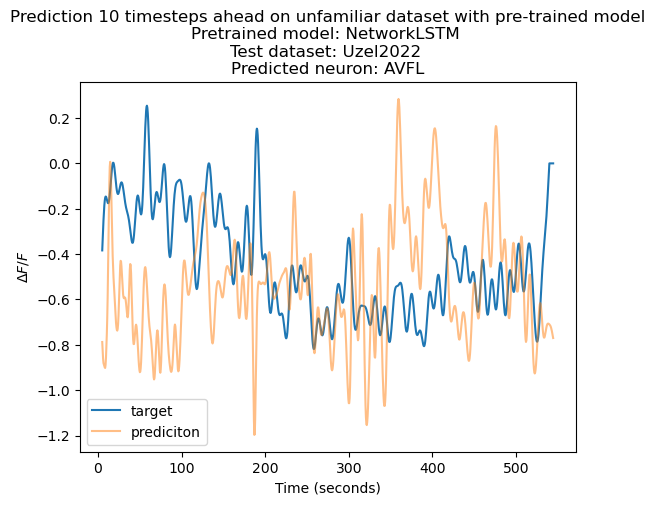

In [12]:
# plot what the predictions looks like
plt.plot(
    time_in_seconds[tau_out : tau_out + max_timesteps // 2],
    targets[:, nidx],
    label="target",
)
plt.plot(
    time_in_seconds[tau_out : tau_out + max_timesteps // 2],
    predictions[:, nidx],
    label="prediciton",
    alpha=0.5,
)
plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("$\Delta F / F$")
plt.title(
    "Prediction %s timesteps ahead on %s dataset with pre-trained model\nPretrained model: %s \nTest dataset: %s \nPredicted neuron: %s"
    % (tau_out, dataset_inclusion_str, model_name, test_dataset_name, neuron_name)
)
plt.show()

In [9]:
# # save predictions across worms and neurons
# now = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
# make_predictions(model, dataset, log_dir="../logs/test/%s"%now, tau=tau_out, smooth_data=smooth_data)
# plot_targets_predictions(log_dir="../logs/test/%s"%now, worm="all", neuron="AVAL")
# plot_correlation_scatterplot(log_dir="../logs/test/%s"%now, worm="all", neuron="AVAL")

In [48]:
# # what if we continue to train a pretrained model but with a different tau?

# # get the same dataset the model was trained on
# dataset_config = OmegaConf.load("../conf/dataset.yaml")
# dataset_config.dataset.name = train_dataset_name.split("_")
# dataset = get_dataset(dataset_config)

# # load the pretrained model
# pretrained_model = model

# # train the model (same dataset but different tau param)
# train_config = OmegaConf.load("../conf/train.yaml")
# train_config.train.tau_in = 7 # modify the tau_in parameter
# train_config.train.epochs = 1
# train_config.train.k_splits = 2
# train_config.train.seq_len = 99
# train_config.train.optimizer = "SGD"
# # print(OmegaConf.to_yaml(train_config))

# now = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
# pretrained_model.train()
# train_model(pretrained_model, dataset, train_config, shuffle=False, log_dir="../logs/test/%s"%now)